#### Oğuz Deniz 201401011
##### YAP441 Project - ARIMA & Prophet Notebook

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [16]:
data = pd.read_csv('BAC.csv')
data['Date'] = pd.to_datetime(data['Date'])
df = data.copy()
df = df[['Adj Close']]
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

ADF Statistic: -1.3588
p-value: 0.6019
Non-Stationary
ARIMA(1,0,1) - MAE: 9.7629, RMSE: 12.1917, Accuracy: 48.45%
ARIMA(1,0,2) - MAE: 9.7370, RMSE: 12.1598, Accuracy: 48.45%
ARIMA(1,0,3) - MAE: 9.7560, RMSE: 12.1823, Accuracy: 48.34%
ARIMA(1,1,1) - MAE: 7.9491, RMSE: 9.8962, Accuracy: 10.82%
ARIMA(1,1,2) - MAE: 7.9502, RMSE: 9.8975, Accuracy: 10.38%
ARIMA(1,1,3) - MAE: 7.9501, RMSE: 9.8974, Accuracy: 9.38%
ARIMA(2,0,1) - MAE: 8.8832, RMSE: 11.0934, Accuracy: 48.34%
ARIMA(2,0,2) - MAE: 9.5097, RMSE: 11.8802, Accuracy: 48.79%
ARIMA(2,0,3) - MAE: 8.5276, RMSE: 10.6383, Accuracy: 48.45%
ARIMA(2,1,1) - MAE: 8.0226, RMSE: 9.9854, Accuracy: 2.43%
ARIMA(2,1,2) - MAE: 7.9591, RMSE: 9.9084, Accuracy: 8.72%
ARIMA(2,1,3) - MAE: 7.9985, RMSE: 9.9561, Accuracy: 48.12%
ARIMA(3,0,1) - MAE: 9.3039, RMSE: 11.6208, Accuracy: 48.34%
ARIMA(3,0,2) - MAE: 8.0680, RMSE: 10.0422, Accuracy: 51.43%
ARIMA(3,0,3) - MAE: 8.0502, RMSE: 10.0208, Accuracy: 49.12%
ARIMA(3,1,1) - MAE: 8.0250, RMSE: 9.9883, Accuracy: 1.8

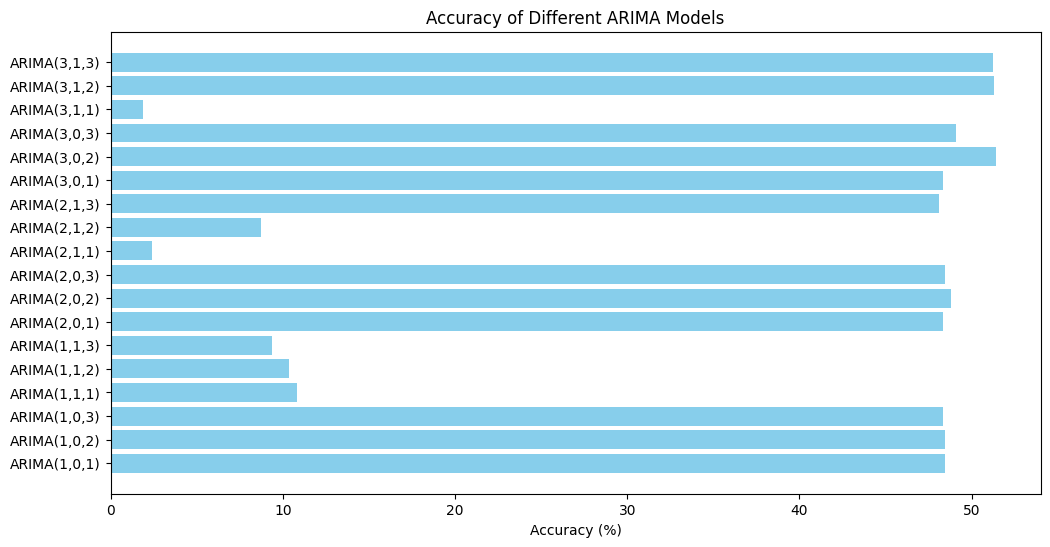

In [17]:
def check_stationarity(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print("Stationary" if result[1] < 0.05 else "Non-Stationary")

check_stationarity(df['Adj Close'])

# Differencing if needed
df['Adj_Close_diff'] = df['Adj Close'].diff().dropna()

def evaluate_arima(p, d, q):
    try:
        # Train ARIMA Model
        model = ARIMA(train['Adj Close'], order=(p, d, q))
        model_fit = model.fit()
        
        # Forecast on Test Set
        predictions = model_fit.forecast(steps=len(test))
        
        # Compute Evaluation Metrics
        mae = mean_absolute_error(test['Adj Close'], predictions)
        rmse = np.sqrt(mean_squared_error(test['Adj Close'], predictions))
        
        # Fix Directional Accuracy Calculation
        actual_directions = np.sign(test['Adj Close'].diff().dropna())  # (N-1) size
        predicted_directions = np.sign(np.diff(predictions))[:len(actual_directions)]  # Truncate predictions
        accuracy = (actual_directions == predicted_directions).mean() * 100  # Percentage

        print(f'ARIMA({p},{d},{q}) - MAE: {mae:.4f}, RMSE: {rmse:.4f}, Accuracy: {accuracy:.2f}%')

        return model_fit, predictions, mae, rmse, accuracy
    except Exception as e:
        print(f"Error with ARIMA({p},{d},{q}): {e}")
        return None, None, None, None, None


best_mae, best_rmse, best_accuracy = float('inf'), float('inf'), 0
best_model, best_predictions = None, None
results = []

p_values = [1, 2, 3]
d_values = [0, 1]
q_values = [1, 2, 3]

for p in p_values:
    for d in d_values:
        for q in q_values:
            model_fit, predictions, mae, rmse, accuracy = evaluate_arima(p, d, q)
            if mae and accuracy:
                results.append((p, d, q, mae, rmse, accuracy))
                if accuracy > best_accuracy:
                    best_mae, best_rmse, best_accuracy = mae, rmse, accuracy
                    best_model, best_predictions = model_fit, predictions

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results, columns=['p', 'd', 'q', 'MAE', 'RMSE', 'Accuracy'])

# Step 6: Plot Accuracy Values for All ARIMA Models
plt.figure(figsize=(12,6))
plt.barh(results_df.index, results_df['Accuracy'], color='skyblue')
plt.yticks(results_df.index, [f"ARIMA({p},{d},{q})" for p, d, q in zip(results_df['p'], results_df['d'], results_df['q'])])
plt.xlabel("Accuracy (%)")
plt.title("Accuracy of Different ARIMA Models")
plt.show()

In [20]:
class StockProphetPredictor:
    def __init__(self, data_path):
        """
        Initialize the predictor with stock data
        
        Parameters:
        -----------
        data_path : str
            Path to the CSV file containing stock data
        """
        # Load and preprocess data
        self.df = pd.read_csv(data_path)
        self.df['Date'] = pd.to_datetime(self.df['Date'])
        
        # Prepare Prophet-compatible dataframe
        self.prophet_df = self.df[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
    
    def create_prediction_label(self, forecast_periods=[1, 7]):
        """
        Create binary labels for price movement
        
        Parameters:
        -----------
        forecast_periods : list
            List of forecast periods in days
        
        Returns:
        --------
        dict of DataFrames with prediction labels
        """
        labels = {}
        for period in forecast_periods:
            # Calculate price change
            self.prophet_df[f'next_{period}_day_change'] = self.prophet_df['y'].shift(-period) - self.prophet_df['y']
            
            # Binary classification: 1 for price increase, 0 for decrease or no change
            self.prophet_df[f'next_{period}_day_direction'] = (self.prophet_df[f'next_{period}_day_change'] > 0).astype(int)
            
            labels[period] = self.prophet_df[[f'next_{period}_day_direction']]
        
        return labels
    
    def train_prophet_models(self, hyperparameters_list):
        """
        Train multiple Prophet models with different hyperparameters
        
        Parameters:
        -----------
        hyperparameters_list : list of dicts
            List of hyperparameter configurations
        
        Returns:
        --------
        dict of trained Prophet models
        """
        models = {}
        for i, params in enumerate(hyperparameters_list, 1):
            model = Prophet(**params)
            model.fit(self.prophet_df[['ds', 'y']])
            models[f'model_{i}'] = model
        
        return models
    
    def evaluate_models(self, models, forecast_periods=[1, 7]):
        """
        Evaluate Prophet models' performance
        
        Parameters:
        -----------
        models : dict
            Trained Prophet models
        forecast_periods : list
            List of forecast periods in days
        
        Returns:
        --------
        dict of model performance metrics
        """
        performance_results = {}
        
        for period in forecast_periods:
            period_results = {}
            
            for model_name, model in models.items():
                # Perform cross-validation
                df_cv = cross_validation(
                    model, 
                    initial='1000 days', 
                    period='180 days', 
                    horizon=f'{period} days'
                )
                
                # Calculate performance metrics
                df_p = performance_metrics(df_cv)
                
                # Prepare actual labels
                actual_labels = self.prophet_df[f'next_{period}_day_direction'].iloc[-len(df_cv):]
                
                # Predict labels
                predicted_labels = (df_cv['yhat'] > df_cv['y']).astype(int)
                
                # Calculate accuracy and classification report
                accuracy = accuracy_score(actual_labels, predicted_labels)
                
                period_results[model_name] = {
                    'accuracy': accuracy,
                    'mse': df_p['mse'].mean(),
                    'mae': df_p['mae'].mean(),
                    'mdape': df_p['mdape'].mean()
                }
            
            performance_results[period] = period_results
        
        return performance_results
    
    def plot_model_comparison(self, performance_results):
        """
        Visualize model performance comparison
        
        Parameters:
        -----------
        performance_results : dict
            Performance metrics for different models
        """
        for period, results in performance_results.items():
            plt.figure(figsize=(10, 6))
            
            # Prepare data for plotting
            models = list(results.keys())
            accuracies = [results[model]['accuracy'] for model in models]
            
            plt.bar(models, accuracies)
            plt.title(f'Model Accuracy Comparison - {period} Day Prediction')
            plt.xlabel('Prophet Model Configurations')
            plt.ylabel('Accuracy')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

17:20:25 - cmdstanpy - INFO - Chain [1] start processing
17:20:26 - cmdstanpy - INFO - Chain [1] done processing
17:20:26 - cmdstanpy - INFO - Chain [1] start processing
17:20:27 - cmdstanpy - INFO - Chain [1] done processing
17:20:27 - cmdstanpy - INFO - Chain [1] start processing
17:20:29 - cmdstanpy - INFO - Chain [1] done processing
17:20:29 - cmdstanpy - INFO - Chain [1] start processing
17:20:30 - cmdstanpy - INFO - Chain [1] done processing
17:20:30 - cmdstanpy - INFO - Chain [1] start processing
17:20:31 - cmdstanpy - INFO - Chain [1] done processing
17:20:31 - cmdstanpy - INFO - Chain [1] start processing
17:20:32 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/31 [00:00<?, ?it/s]17:20:33 - cmdstanpy - INFO - Chain [1] start processing
17:20:33 - cmdstanpy - INFO - Chain [1] done processing
  3%|▎         | 1/31 [00:00<00:09,  3.02it/s]17:20:33 - cmdstanpy - INFO - Chain [1] start processing
17:20:33 - cmdstanpy - INFO - Chain [1] done processing
  6%|▋      


Performance for 1-Day Prediction:

model_1 Metrics:
  ACCURACY: 0.6129
  MSE: 21.3229
  MAE: 3.6910
  MDAPE: 0.1428

model_2 Metrics:
  ACCURACY: 0.6129
  MSE: 21.3229
  MAE: 3.6910
  MDAPE: 0.1428

model_3 Metrics:
  ACCURACY: 0.6129
  MSE: 19.6685
  MAE: 3.3882
  MDAPE: 0.1336

model_4 Metrics:
  ACCURACY: 0.6129
  MSE: 21.1978
  MAE: 3.6818
  MDAPE: 0.1421

model_5 Metrics:
  ACCURACY: 0.6129
  MSE: 21.3229
  MAE: 3.6910
  MDAPE: 0.1428

model_6 Metrics:
  ACCURACY: 0.6129
  MSE: 21.3229
  MAE: 3.6910
  MDAPE: 0.1428

Performance for 7-Day Prediction:

model_1 Metrics:
  ACCURACY: 0.5067
  MSE: 20.1945
  MAE: 3.5763
  MDAPE: 0.1691

model_2 Metrics:
  ACCURACY: 0.5067
  MSE: 20.1945
  MAE: 3.5763
  MDAPE: 0.1691

model_3 Metrics:
  ACCURACY: 0.5200
  MSE: 17.5375
  MAE: 3.1490
  MDAPE: 0.1176

model_4 Metrics:
  ACCURACY: 0.5133
  MSE: 20.1230
  MAE: 3.5575
  MDAPE: 0.1681

model_5 Metrics:
  ACCURACY: 0.5067
  MSE: 20.1945
  MAE: 3.5763
  MDAPE: 0.1691

model_6 Metrics:
  ACCURACY

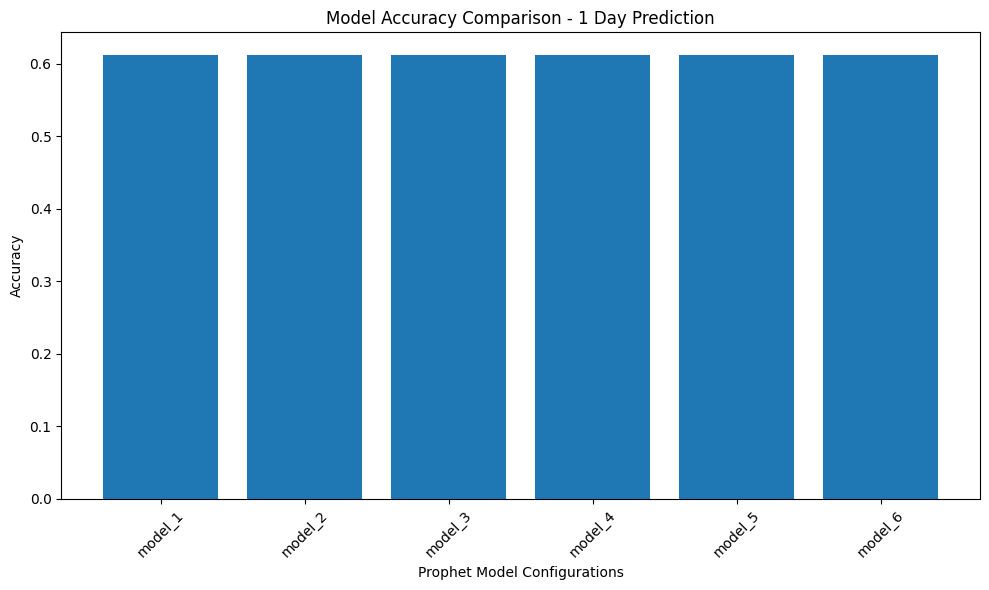

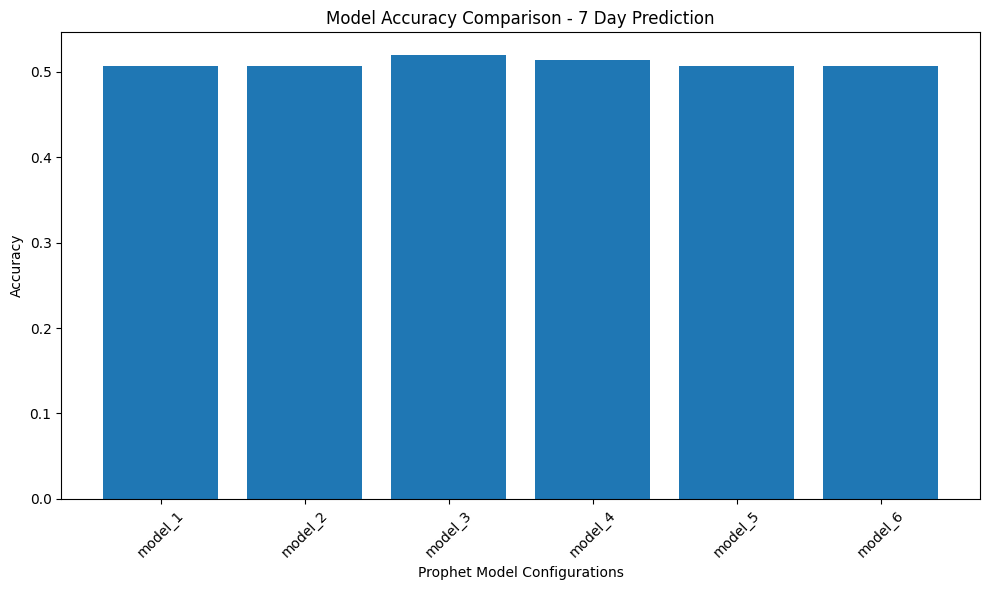

In [21]:
def main():
    # Load and prepare data
    predictor = StockProphetPredictor('BAC.csv')
    
    # Create prediction labels
    labels = predictor.create_prediction_label(forecast_periods=[1, 7])
    
    # Define different Prophet model hyperparameter configurations
    hyperparameters_list = [
        {},  # Default configuration
        {'changepoint_prior_scale': 0.05},  # Less flexible trend
        {'changepoint_prior_scale': 0.5},   # More flexible trend
        {'seasonality_prior_scale': 0.1},   # Less seasonal variation
        {'seasonality_prior_scale': 10},    # More seasonal variation
        {'holidays_prior_scale': 0.1},      # Less holiday impact
    ]
    
    # Train models
    models = predictor.train_prophet_models(hyperparameters_list)
    
    # Evaluate models
    performance_results = predictor.evaluate_models(models, forecast_periods=[1, 7])
    
    # Print detailed performance results
    for period, results in performance_results.items():
        print(f"\nPerformance for {period}-Day Prediction:")
        for model, metrics in results.items():
            print(f"\n{model} Metrics:")
            for metric, value in metrics.items():
                print(f"  {metric.upper()}: {value:.4f}")
    
    # Visualize model comparisons
    predictor.plot_model_comparison(performance_results)

if __name__ == '__main__':
    main()